https://natasha-klingenbrunn.medium.com/transformer-implementation-for-time-series-forecasting-a9db2db5c820

In [ ]:
## import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Optional, just for confirmation

Using device: cuda


In [ ]:
test_data_import = pd.read_csv("/content/drive/MyDrive/results/test_data_not_normalised.csv")
train_data_nn_pre = pd.read_csv("/content/drive/MyDrive/results/train_data_not_normalised.csv")
val_data_nn_pre = test_data_import[test_data_import["patient_id"] == 'INH111'].copy()
test_data_nn_pre = test_data_import[test_data_import["patient_id"] != 'INH111'].copy()

print(f"Training Data has unique patient of [{train_data_nn_pre['patient_id'].unique()}]")
print(f"Testing Data has unique patient of [{test_data_nn_pre['patient_id'].unique()}]")
print(f"Validation Data has unique patient of [{val_data_nn_pre['patient_id'].unique()}]")
print(len(train_data_nn_pre), len(test_data_nn_pre), len(val_data_nn_pre))
print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()), len(val_data_nn_pre["patient_id"].unique()))

Training Data has unique patient of [['INH001' 'INH004' 'INH007' 'INH010' 'INH011' 'INH012' 'INH015' 'INH127'
 'INH018' 'INH023' 'INH024' 'INH028' 'INH100' 'INH101' 'INH102' 'INH107'
 'INH114' 'INH108' 'INH109' 'INH110' 'INH112' 'INH115' 'INH119' 'INH120'
 'INH121' 'INH123' 'INH128' 'INH131' 'INH138' 'INH139']]
Testing Data has unique patient of [['INH002' 'INH003' 'INH006' 'INH013' 'INH014' 'INH017' 'INH025' 'INH027'
 'INH103' 'INH106' 'INH113' 'INH117' 'INH135']]
Validation Data has unique patient of [['INH111']]
326894 159025 12738
30 13 1


In [ ]:
train_data_nn_pre

,Unnamed: 0,patient_id,age_x,sex_x,season_x,br_avg,br_std,act_level,step_count,activity,...,pm10,no,no2,o3,so2,co,sex_y,age_y,cubic_meterers_tv,inhale_tv
0,0,INH001,65,Female,Winter,19.542938,6.395616,0.116685,0,Sitting bent backwards,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000573
1,1,INH001,65,Female,Winter,20.762518,2.593489,0.066786,0,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000613
2,2,INH001,65,Female,Winter,19.246227,2.828573,0.012011,0,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000560
3,3,INH001,65,Female,Winter,17.215359,4.588334,0.016393,0,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000550
4,4,INH001,65,Female,Winter,17.300472,2.968072,0.071856,9,Lying down on back,...,6.26,0.00,7.80,77.96,3.73,223.64,Female,65,0.000335,0.000707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326889,526497,INH139,47,Female,Winter,14.888110,0.611812,0.013874,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000176
326890,526498,INH139,47,Female,Winter,14.972208,0.887404,0.014606,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000156
326891,526499,INH139,47,Female,Winter,15.359121,1.316184,0.014437,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000134
326892,526500,INH139,47,Female,Winter,15.506245,1.020111,0.014413,0,Lying down to the left,...,37.16,139.47,74.03,0.00,56.74,674.25,Female,47,0.000284,0.000108


In [ ]:
train_data_nn = train_data_nn_pre.copy()
test_data_nn = test_data_nn_pre.copy()

In [ ]:
train_data_nn.columns

Index(['Unnamed: 0', 'patient_id', 'age_x', 'sex_x', 'season_x', 'br_avg',
       'br_std', 'act_level', 'step_count', 'activity', 'latitude_x',
       'longitude_x', 'season_y', 'pm2_5_x', 'temperature', 'humidity',
       'time_diff', 'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round', 'pm10', 'no', 'no2', 'o3',
       'so2', 'co', 'sex_y', 'age_y', 'cubic_meterers_tv', 'inhale_tv'],
      dtype='object')

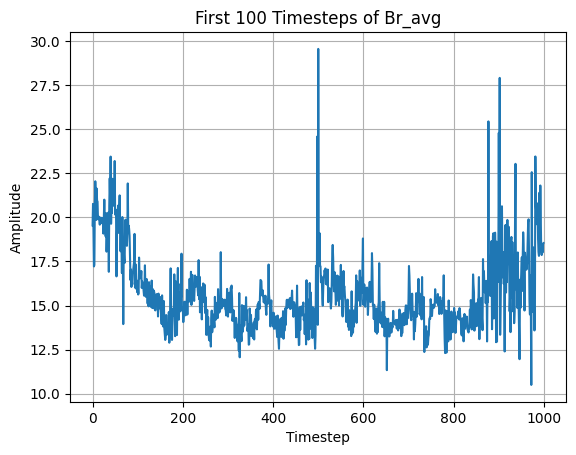

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_data_nn['br_avg'][:1000])
plt.title("First 100 Timesteps of Br_avg")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [ ]:
from torch.utils.data import Dataset, DataLoader
# ============================== DEFINING INDIVIDUAL POSITIONING WITHIN DIFFERENT BATCHES ============================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return x

# ============================== DEFINING CLASS DATASET TO HANDLE THE DATA ============================
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size=8, forecast_steps=1, step=1):
        """
        Similar to professor's concat_timesteps but as a PyTorch Dataset
        """
        self.window_size = window_size
        self.forecast_steps = forecast_steps
        self.step = step

        # Create sliding windows
        n_samples, n_features = data.shape
        num_windows = (n_samples - window_size - forecast_steps) // step + 1

        self.windows = []
        self.targets = []

        for i in range(num_windows):
            start = i * step
            window = data[start:start + window_size]
            target = data[start + window_size:start + window_size + forecast_steps]

            self.windows.append(window)
            self.targets.append(target)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = torch.FloatTensor(self.windows[idx])
        target = torch.FloatTensor(self.targets[idx])

        # For single step prediction, squeeze the target
        if self.forecast_steps == 1:
            target = target.squeeze(0)

        return window, target


In [ ]:
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=False)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False
        )
        src2 = self.dropout1(attn_output)
        src = self.norm1(src + src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(src2))
        return src, attn_weights



class VariationalTimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_features: int = 11,
        d_model: int = 128,
        latent_dim: int = 64,  # New: Latent dimension
        nhead: int = 8,
        num_layers: int = 6,
        dim_feedforward: int = 512,
        dropout: float = 0.2,
        forecast_steps: int = 1,
        output_features: int = 11
    ):
        super().__init__()

        self.input_proj = nn.Linear(input_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        ## trying to plot attention's map

        self.encoder_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ) for _ in range(num_layers)
        ])



        # encoder_layer = nn.TransformerEncoderLayer(
        #     d_model=d_model,
        #     nhead=nhead,
        #     dim_feedforward=dim_feedforward,
        #     dropout=dropout,
        # )
        # self.transformer_encoder = nn.TransformerEncoder(
        #     encoder_layer,
        #     num_layers=num_layers,
        # )

        # Latent projection
        self.mean_layer = nn.Linear(d_model, latent_dim)
        self.logvar_layer = nn.Linear(d_model, latent_dim)

        # Decoder maps from latent space → forecast
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, output_features * forecast_steps),
        )

        self.d_model = d_model
        self.latent_dim = latent_dim
        self.forecast_steps = forecast_steps
        self.output_features = output_features

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, src: torch.Tensor):
        """
        Args:
            src: (seq_len, batch, input_features)
        Returns:
            recon: (batch, forecast_steps, output_features)
            mu: (batch, latent_dim)
            logvar: (batch, latent_dim)
        """
        x = self.input_proj(src) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)

        # enc_out = self.transformer_encoder(x)  # (seq_len, batch, d_model)
        #pLOTTING ATTENTION'S MAP
        attentions = []
        for layer in self.encoder_layers:
          x, attn_weights = layer(x)
          attentions.append(attn_weights)
        enc_out = x


        # Take last time-step
        last = enc_out[-1, :, :]  # (batch, d_model)

        # Latent space
        mu = self.mean_layer(last)      # (batch, latent_dim)
        logvar = self.logvar_layer(last)  # (batch, latent_dim)

        # Sample from latent distribution
        z = self.reparameterize(mu, logvar)  # (batch, latent_dim)

        # Decode
        recon = self.decoder(z)  # (batch, forecast_steps * output_features)

        if self.forecast_steps > 1:
            recon = recon.view(-1, self.forecast_steps, self.output_features)

        return recon, mu, logvar, attentions


In [ ]:
class LatentDiscriminator(nn.Module):
    def __init__(self, latent_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output: probability z is from N(0, I)
        )

    def forward(self, z):
        return self.net(z)

In [ ]:
import torch.nn.functional as F
from torch.nn import BCELoss

def train_model_aae(
    model,
    train_loader,
    val_loader,
    optimizer,
    discriminator,
    disc_optimizer,
    device,
    epochs=30,
    patience=5,
    min_delta=1e-4,
    adv_weight=0.01  # controls strength of adversarial regularization
):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    adversarial_loss = BCELoss()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        discriminator.train()
        total_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)
            targets = targets.to(device)

            # ======== Phase 1: Train Discriminator ========
            with torch.no_grad():
                # Corrected unpacking to expect 4 values
                outputs, mu, logvar, _ = model(inputs)

                z_fake = model.reparameterize(mu, logvar).detach()

            z_real = torch.randn_like(z_fake).to(device)

            real_labels = torch.ones(z_real.size(0), 1).to(device)
            fake_labels = torch.zeros(z_fake.size(0), 1).to(device)

            disc_optimizer.zero_grad()
            real_preds = discriminator(z_real)
            fake_preds = discriminator(z_fake)

            disc_loss = adversarial_loss(real_preds, real_labels) + \
                        adversarial_loss(fake_preds, fake_labels)
            disc_loss.backward()
            disc_optimizer.step()

            # ======== Phase 2: Train VAE Generator ========
            optimizer.zero_grad()
            # Corrected unpacking to expect 4 values
            outputs, mu, logvar, attentions = model(inputs)

            z_gen = model.reparameterize(mu, logvar)

            gen_preds = discriminator(z_gen)
            adv_loss = adversarial_loss(gen_preds, real_labels)

            if model.forecast_steps > 1:
                outputs = outputs.view(targets.shape[0], targets.shape[1], targets.shape[2])

            recon_loss = F.mse_loss(outputs, targets, reduction='mean')
            loss = recon_loss + adv_weight * adv_loss

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # ======== Validation Phase ========
        model.eval()
        discriminator.eval()  # Add this line to set discriminator to eval mode
        total_val_loss = 0.0
        total_val_recon = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.permute(1, 0, 2).to(device)
                targets = targets.to(device)

                # Corrected unpacking to expect 4 values
                outputs, mu, logvar, _ = model(inputs)

                if model.forecast_steps > 1:
                    outputs = outputs.view(targets.shape[0], targets.shape[1], targets.shape[2])

                recon_loss = F.mse_loss(outputs, targets, reduction='mean')
                val_loss = recon_loss  # no KL in AAE-style

                total_val_loss += val_loss.item()
                total_val_recon += recon_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_recon = total_val_recon / len(val_loader)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f} - Recon: {avg_val_recon:.6f} - Disc Loss: {disc_loss.item():.6f} - Adv Loss: {adv_loss.item():.6f}")

        # Early Stopping
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch} - Best Val Loss: {best_val_loss:.6f}")
                break

In [ ]:
## Useful to filter down!

print(train_data_nn_pre["patient_id"].unique(), test_data_nn_pre["patient_id"].unique())
print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()))

train_data_nn_pre = train_data_nn_pre[train_data_nn_pre["patient_id"].isin(['INH001','INH003', 'INH006', 'INH106' ,'INH114' ,'INH110'])]
test_data_nn_pre = test_data_nn_pre[test_data_nn_pre["patient_id"].isin(['INH012','INH014','INH107' ])]

print(train_data_nn_pre["patient_id"].unique(), test_data_nn_pre["patient_id"].unique())
print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()))

['INH001' 'INH114' 'INH110'] ['INH014']
3 1
['INH001' 'INH114' 'INH110'] ['INH014']
3 1


In [ ]:
train_data_nn_pre.columns

Index(['Unnamed: 0', 'patient_id', 'age_x', 'sex_x', 'season_x', 'br_avg',
       'br_std', 'act_level', 'step_count', 'activity', 'latitude_x',
       'longitude_x', 'season_y', 'pm2_5_x', 'temperature', 'humidity',
       'time_diff', 'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round', 'pm10', 'no', 'no2', 'o3',
       'so2', 'co', 'sex_y', 'age_y', 'cubic_meterers_tv', 'inhale_tv'],
      dtype='object')

In [ ]:
## ================= INSTANTIATING AND CALLING THE MODEL ==================

# Hyperparameters
window_size = 8
forecast_steps = 1
batch_size = 32
d_model = 128
nhead = 8
num_layers = 6
dim_feedforward = 512
dropout = 0.2
lr = 1e-3
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_train = train_data_nn_pre.copy()
data_test = test_data_nn_pre.copy()


feature_cols = ['br_avg', 'br_std', 'act_level', 'step_count','pm2_5_x', 'temperature', 'humidity', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin',
       'yearly_cos', 'lat_round', 'lon_round','pm10', 'no', 'no2', 'o3', 'so2', 'co','inhale_tv']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train[feature_cols])

train_data = scaler.transform(data_train[feature_cols])
test_data = scaler.transform(data_test[feature_cols])

# Create datasets
train_dataset = SlidingWindowDataset(train_data, window_size, forecast_steps)
test_dataset = SlidingWindowDataset(test_data, window_size, forecast_steps)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = VariationalTimeSeriesTransformer(
    input_features=len(feature_cols),
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    forecast_steps=forecast_steps,
    output_features=len(feature_cols)
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

discriminator = LatentDiscriminator(latent_dim=model.latent_dim).to(device)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# Train
train_model_aae(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    discriminator=discriminator,
    disc_optimizer=disc_optimizer,
    device=device,
    epochs=epochs,
    adv_weight=0.01  # adjust this
)

Epoch 1/3 - Train Loss: 0.013902 - Val Loss: 0.006221 - Recon: 0.006221 - Disc Loss: 1.401260 - Adv Loss: 0.680331
Epoch 2/3 - Train Loss: 0.009902 - Val Loss: 0.005308 - Recon: 0.005308 - Disc Loss: 1.403818 - Adv Loss: 0.681889
Epoch 3/3 - Train Loss: 0.009354 - Val Loss: 0.005035 - Recon: 0.005035 - Disc Loss: 1.373581 - Adv Loss: 0.722179


In [ ]:
def evaluate_model(model, dataloader, device, scaler=None, feature_names=None):
    """
    Evaluate the model and plot predictions vs actual values for all features
    Similar to professor's plotting code but adapted for transformer

    Args:
        model: Trained model
        dataloader: DataLoader with test data
        device: torch device
        scaler: Optional scaler for inverse transformation
        feature_names: List of feature names for plotting
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)
            outputs, mu, logvar = model(inputs) # Corrected unpacking to expect 3 values

            # Store predictions and targets
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Concatenate all batches
    preds = np.concatenate(all_preds, axis=0)
    trues = np.concatenate(all_targets, axis=0)

    # If we predicted multiple steps, average them for visualization
    if preds.ndim == 3:  # (samples, forecast_steps, features)
        preds = preds.mean(axis=1)  # Average across forecast steps
        trues = trues.mean(axis=1)

    # Inverse transform if scaler is provided
    if scaler is not None:
        # Need to create dummy arrays with same shape as original data
        dummy_cols = scaler.n_features_in_

        # Create containers for inverse transform
        preds_full = np.zeros((len(preds), dummy_cols))
        trues_full = np.zeros((len(trues), dummy_cols))

        # Only fill the columns we predicted
        preds_full[:, :preds.shape[1]] = preds
        trues_full[:, :trues.shape[1]] = trues

        # Inverse transform
        preds = scaler.inverse_transform(preds_full)[:, :preds.shape[1]]
        trues = scaler.inverse_transform(trues_full)[:, :trues.shape[1]]

    # Plot each feature separately
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(preds.shape[1])]

    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(12, 6))

        # Plot first 100 samples for clarity
        plt.plot(trues[:500, i], 'b-', label='Actual', linewidth=2)
        plt.plot(preds[:500, i], 'r--', label='Predicted', linewidth=2)

        plt.title(f'Prediction vs Actual: {feature}', fontsize=14)
        plt.xlabel('Time Steps', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return preds, trues

feature_names = feature_cols
# Evaluate and plot
preds, trues = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device,
    scaler=scaler,
    feature_names=feature_names
)

# Additional metrics calculation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\nOverall Metrics:")
print(f"MSE: {mean_squared_error(trues, preds):.4f}")
print(f"MAE: {mean_absolute_error(trues, preds):.4f}")
print(f"R² Score: {r2_score(trues, preds):.4f}")

# Per-feature metrics
print("\nPer-feature Metrics:")
for i, feature in enumerate(feature_names):
    mse = mean_squared_error(trues[:, i], preds[:, i])
    mae = mean_absolute_error(trues[:, i], preds[:, i])
    r2 = r2_score(trues[:, i], preds[:, i])

    print(f"{feature}:")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

ValueError: too many values to unpack (expected 3)

In [ ]:
def evaluate_model_hourly(model, dataloader, device, scaler=None, feature_names=None):
    """
    Evaluate the model and plot hourly-aggregated predictions vs actual values.

    Args:
        model: Trained model
        dataloader: DataLoader with test data
        device: torch device
        scaler: Optional scaler for inverse transformation
        feature_names: List of feature names for plotting
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.permute(1, 0, 2).to(device)  # (seq_len, batch, features)
            outputs, mu, logvar = model(inputs) # Corrected unpacking

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    trues = np.concatenate(all_targets, axis=0)

    # Average across forecast steps if needed
    if preds.ndim == 3:
        preds = preds.mean(axis=1)
        trues = trues.mean(axis=1)

    # Inverse transform if needed
    if scaler is not None:
        dummy_cols = scaler.n_features_in_
        preds_full = np.zeros((len(preds), dummy_cols))
        trues_full = np.zeros((len(trues), dummy_cols))
        preds_full[:, :preds.shape[1]] = preds
        trues_full[:, :trues.shape[1]] = trues
        preds = scaler.inverse_transform(preds_full)[:, :preds.shape[1]]
        trues = scaler.inverse_transform(trues_full)[:, :trues.shape[1]]

    # ==== Hourly aggregation (average over every 60 timesteps) ====
    def aggregate_hourly(data, interval=60):
        n = len(data) // interval
        return data[:n * interval].reshape(n, interval, -1).mean(axis=1)

    preds_hourly = aggregate_hourly(preds)
    trues_hourly = aggregate_hourly(trues)

    # Plot each feature
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(preds_hourly.shape[1])]

    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(12, 6))
        plt.plot(trues_hourly[:100, i], 'b-', label='Actual (hourly)', linewidth=2)
        plt.plot(preds_hourly[:100, i], 'r--', label='Predicted (hourly)', linewidth=2)
        plt.title(f'Hourly Prediction vs Actual: {feature}', fontsize=14)
        plt.xlabel('Hour')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return preds_hourly, trues_hourly

# Run hourly evaluation
preds_hourly, trues_hourly = evaluate_model_hourly(
    model=model,
    dataloader=test_loader,
    device=device,
    scaler=scaler,
    feature_names=feature_cols
)

# Hourly-level metrics
print("\nHourly Aggregated Metrics:")
print(f"MSE: {mean_squared_error(trues_hourly, preds_hourly):.4f}")
print(f"MAE: {mean_absolute_error(trues_hourly, preds_hourly):.4f}")
print(f"R² Score: {r2_score(trues_hourly, preds_hourly):.4f}")

# Per-feature metrics
print("\nPer-feature Hourly Metrics:")
for i, feature in enumerate(feature_cols):
    mse = mean_squared_error(trues_hourly[:, i], preds_hourly[:, i])
    mae = mean_absolute_error(trues_hourly[:, i], preds_hourly[:, i])
    r2 = r2_score(trues_hourly[:, i], preds_hourly[:, i])
    print(f"{feature}:")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

## Now Applying on one individual only

In [ ]:
import copy
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

# ========================= 1. Extract and Normalize Individual Data =========================

## My individual id is --> 'INH111'
individual_id = 'INH111'


# Scale individual data using previously fitted scaler
val_data_nn_scaled = scaler.transform(val_data_nn_pre[feature_cols])

# ========================= 2. Wrap Individual Data in Dataset =========================

val_dataset = SlidingWindowDataset(val_data_nn_scaled, window_size, forecast_steps)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# ========================= 3. Clone & Prepare Model =========================

# Clone original model for safe fine-tuning
fine_tune_model = copy.deepcopy(model).to(device)

# # Optionally freeze encoder to avoid catastrophic forgetting
# for param in fine_tune_model.transformer_encoder.parameters():
#     param.requires_grad = False  # 🔒 freeze transformer encoder

# # New optimizer for fine-tuning (smaller LR)
# fine_tune_optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, fine_tune_model.parameters()),
#     lr=1e-4
# )
# fine_tune_disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-5)

# ========================= 4. Fine-tune on Individual =========================

fine_tune_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, fine_tune_model.parameters()),
    lr=1e-4
)

fine_tune_disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-5)


train_model_aae(
    model=fine_tune_model,
    train_loader=val_loader,
    val_loader=val_loader,
    optimizer=fine_tune_optimizer,
    discriminator=discriminator,
    disc_optimizer=fine_tune_disc_optimizer,
    device=device,
    epochs=5,         # 🔁 Small number of epochs for personalization
    adv_weight=0.01   # Balance reconstruction & latent regularization
)

# ========================= 5. Evaluate on Individual =========================

print(f"\n🔍 Evaluation on Individual: {individual_id}")
preds_ind, trues_ind = evaluate_model(
    model=fine_tune_model,
    dataloader=val_loader,
    device=device,
    scaler=scaler,
    feature_names=feature_cols
)

# Hourly-level evaluation
print(f"\n🕒 Hourly Aggregated Evaluation for {individual_id}")
preds_hourly_ind, trues_hourly_ind = evaluate_model_hourly(
    model=fine_tune_model,
    dataloader=val_loader,
    device=device,
    scaler=scaler,
    feature_names=feature_cols
)

# ========================= 6. Metrics =========================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n🔢 Individual Metrics:")
print(f"MSE: {mean_squared_error(trues_ind, preds_ind):.4f}")
print(f"MAE: {mean_absolute_error(trues_ind, preds_ind):.4f}")
print(f"R² Score: {r2_score(trues_ind, preds_ind):.4f}")

print("\n📊 Per-feature Metrics:")
for i, feature in enumerate(feature_cols):
    mse = mean_squared_error(trues_ind[:, i], preds_ind[:, i])
    mae = mean_absolute_error(trues_ind[:, i], preds_ind[:, i])
    r2 = r2_score(trues_ind[:, i], preds_ind[:, i])
    print(f"{feature}: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# ========================= 7. Save Fine-Tuned Model =========================

torch.save(fine_tune_model.state_dict(), f"model_{individual_id}_finetuned.pt")
print(f"\n✅ Fine-tuned model for {individual_id} saved to model_{individual_id}_finetuned.pt")


In [ ]:
model.eval()

# Take 1 sample from training set
sample_input, _ = train_dataset[0]  # shape: (window_size, num_features)

# Add batch dimension and permute to (seq_len, batch, features)
sample_input = sample_input.unsqueeze(1).to(device)

# Run through model
with torch.no_grad():
    _, _, _, attentions = model(sample_input)


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_attention(attn, layer=0, head=0, time_labels=None):
#     """
#     attn: List of attention tensors from model
#           each of shape (batch_size, num_heads, seq_len, seq_len)
#     layer: which layer to visualize
#     head: which attention head to visualize
#     time_labels: optional list of strings for axis labels
#     """
#     attn_layer = attn[layer]  # (batch, heads, seq_len, seq_len)
#     attn_matrix = attn_layer[0, head].detach().cpu().numpy()  # (seq_len, seq_len)

#     if time_labels is None:
#         time_labels = [f"t{i}" for i in range(attn_matrix.shape[0])]

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(attn_matrix, xticklabels=time_labels, yticklabels=time_labels, cmap="viridis", square=True)
#     plt.title(f"Attention Map — Layer {layer}, Head {head}")
#     plt.xlabel("Key (past positions)")
#     plt.ylabel("Query (current positions)")
#     plt.show()


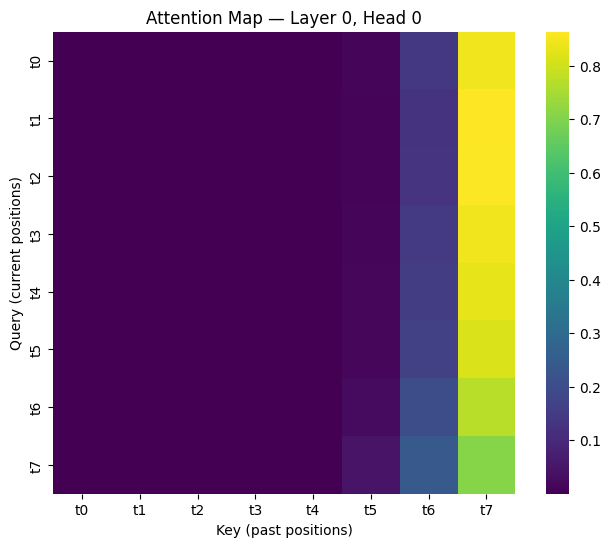

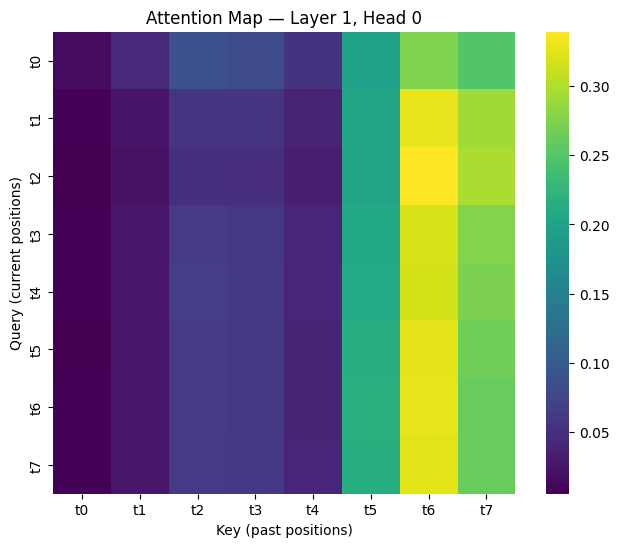

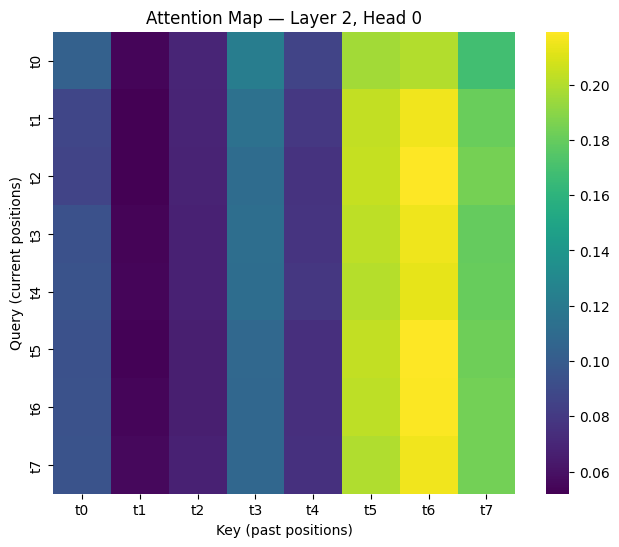

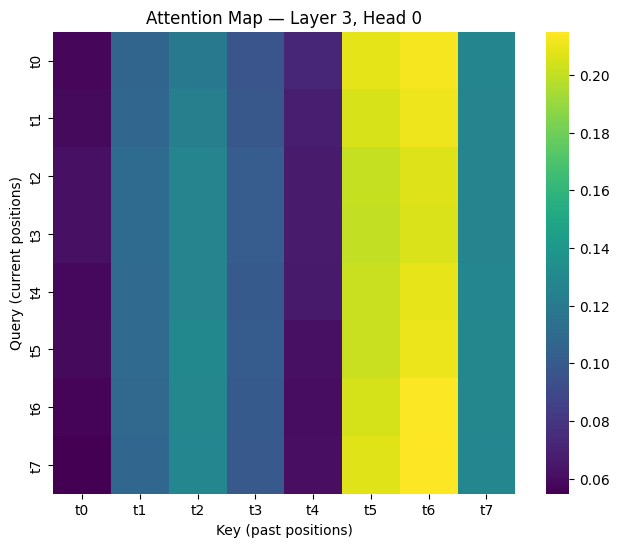

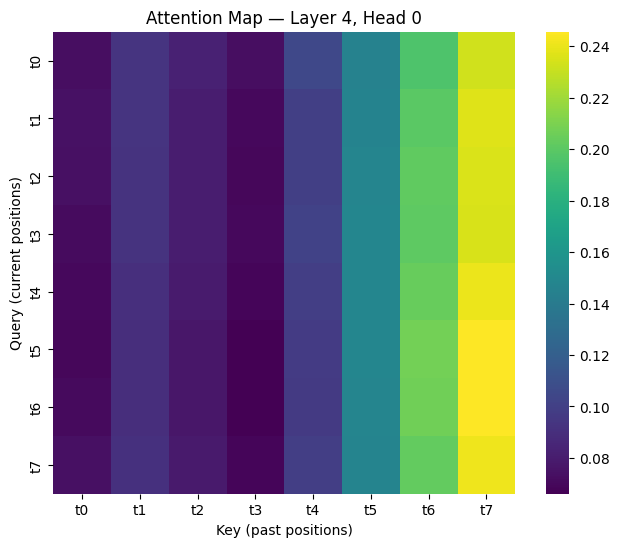

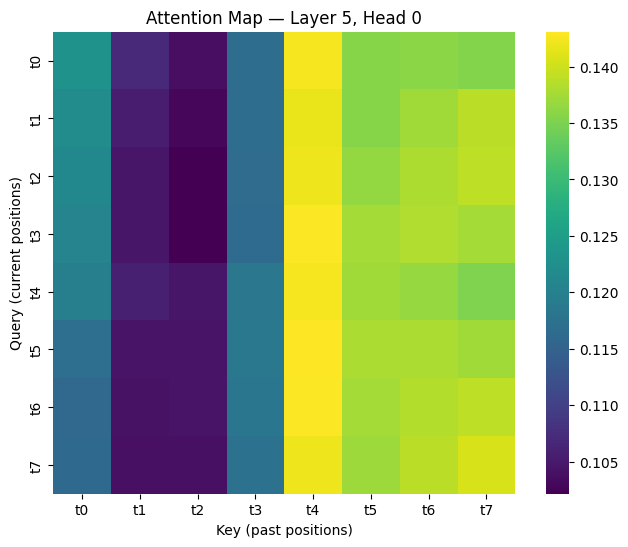

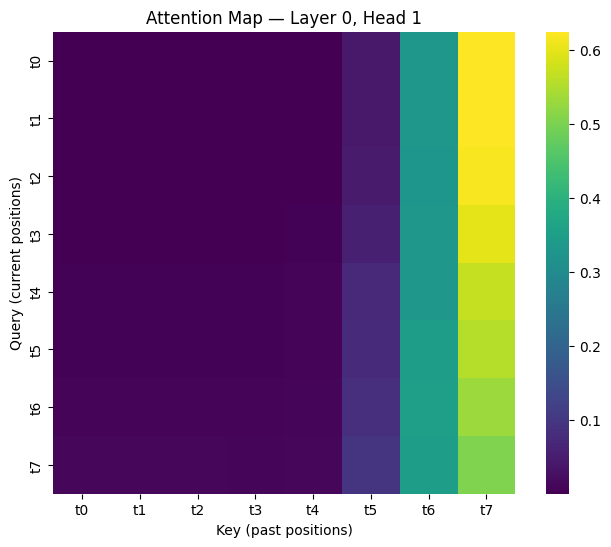

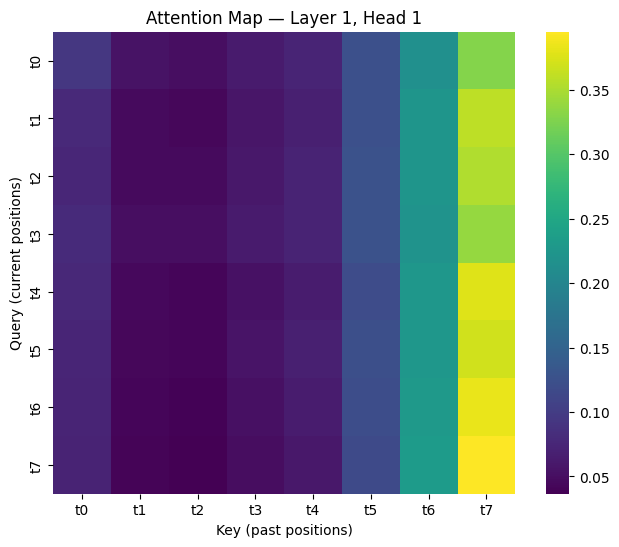

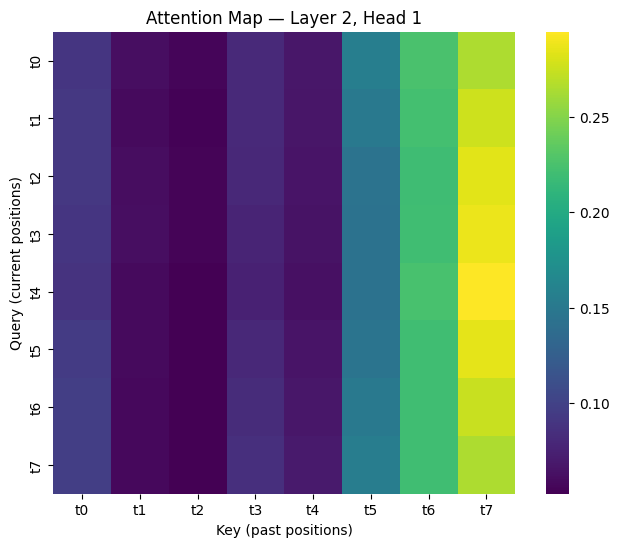

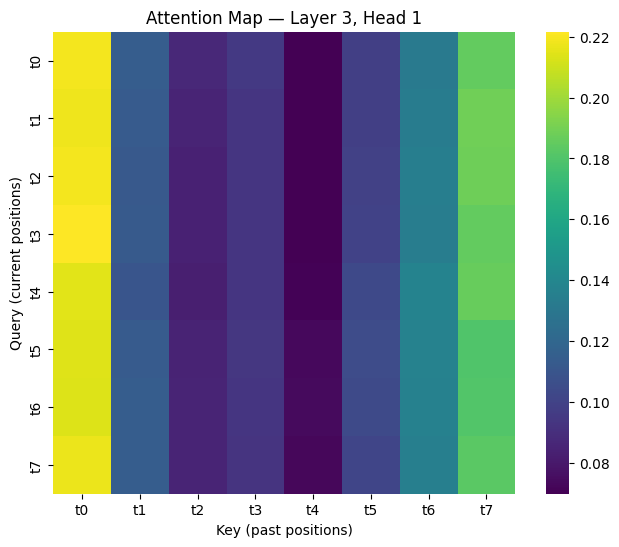

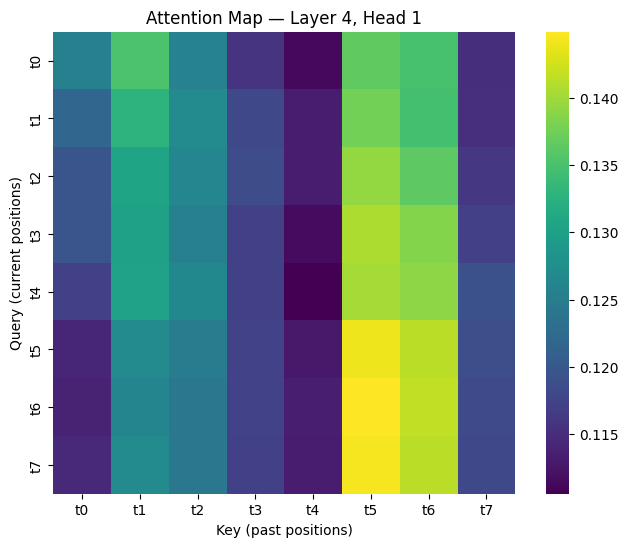

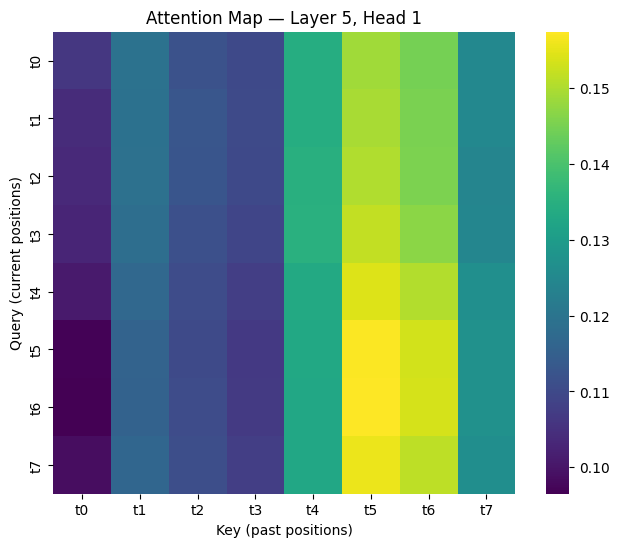

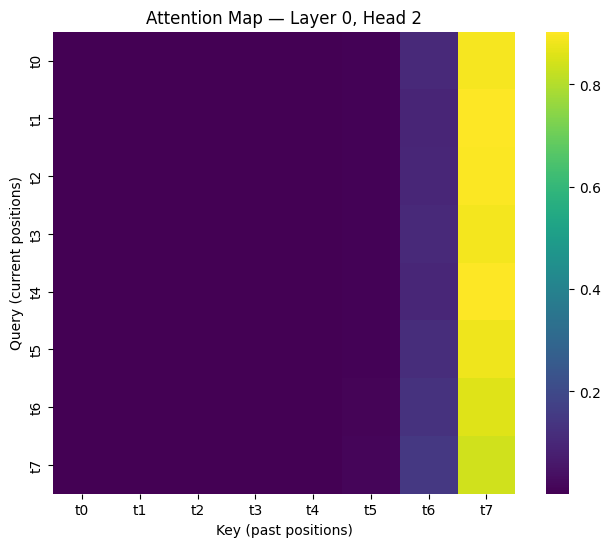

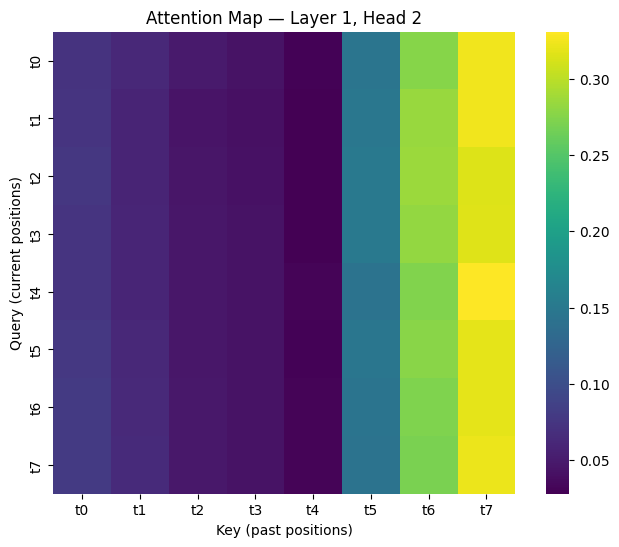

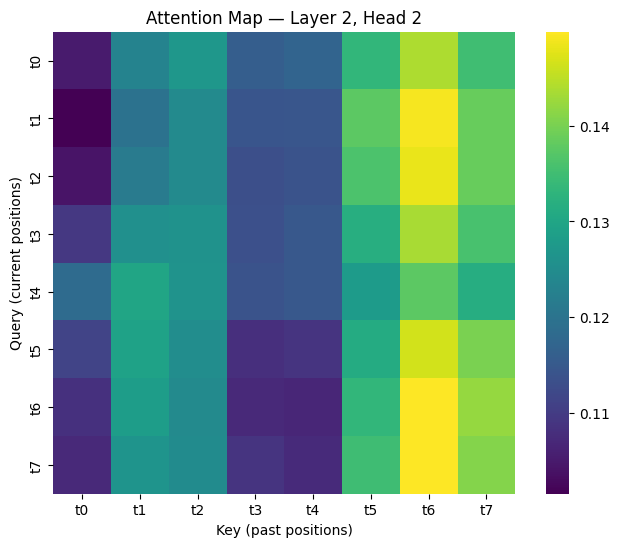

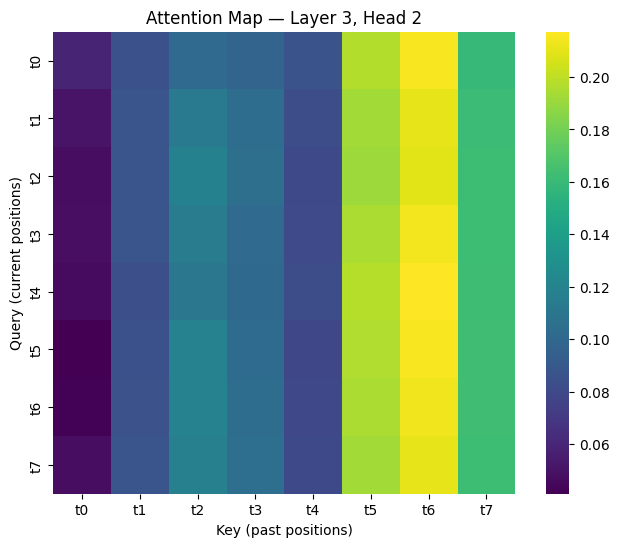

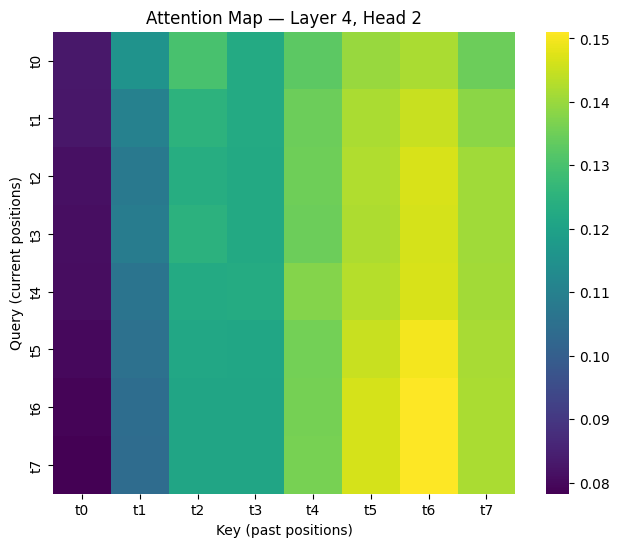

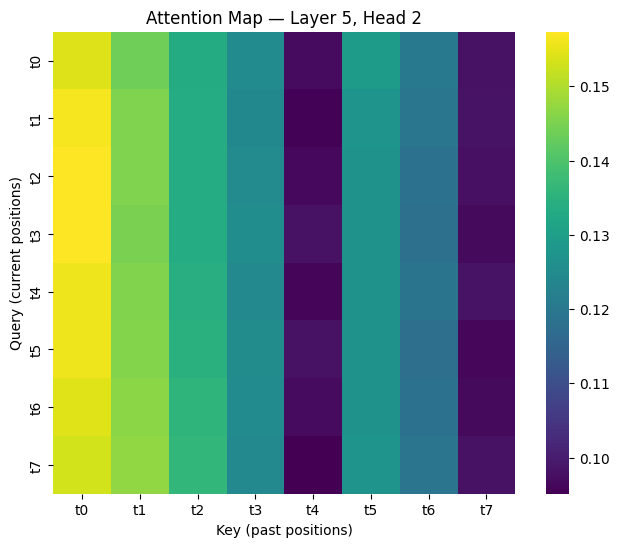

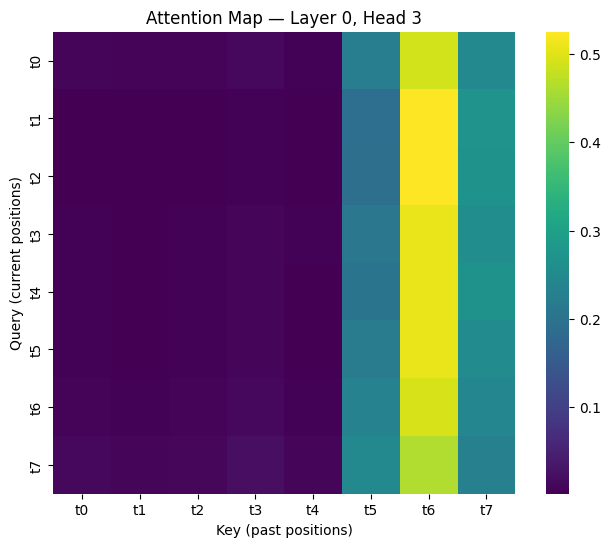

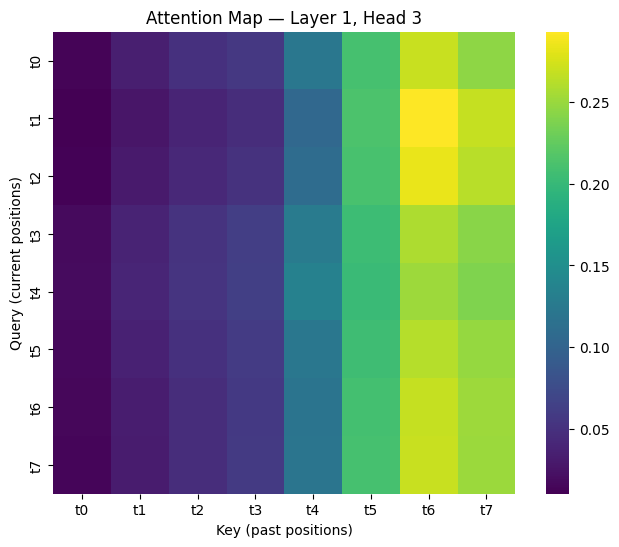

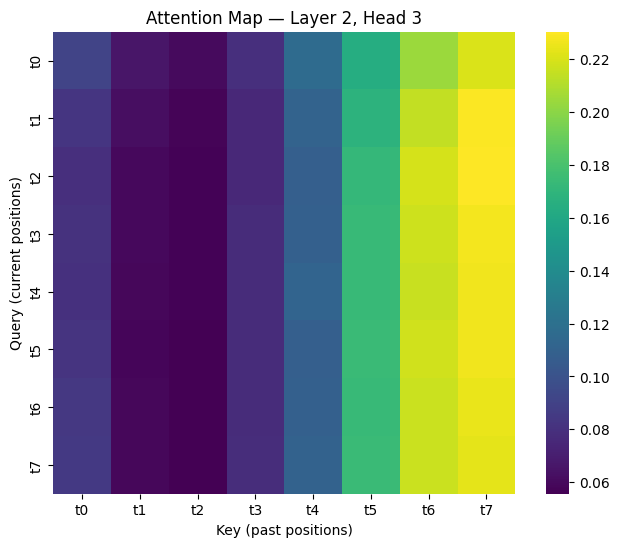

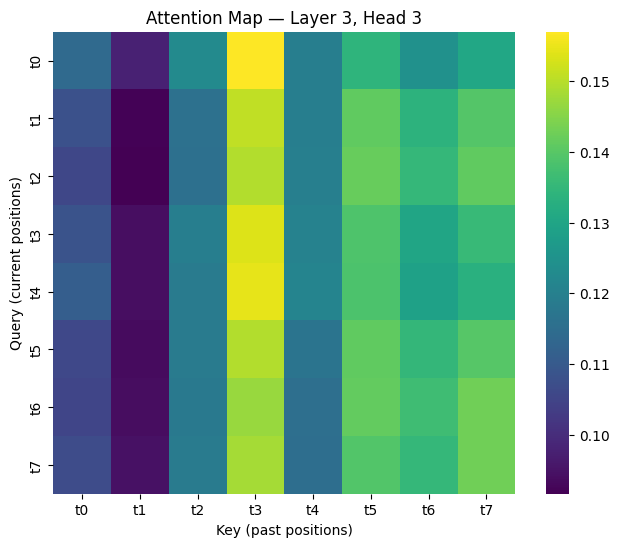

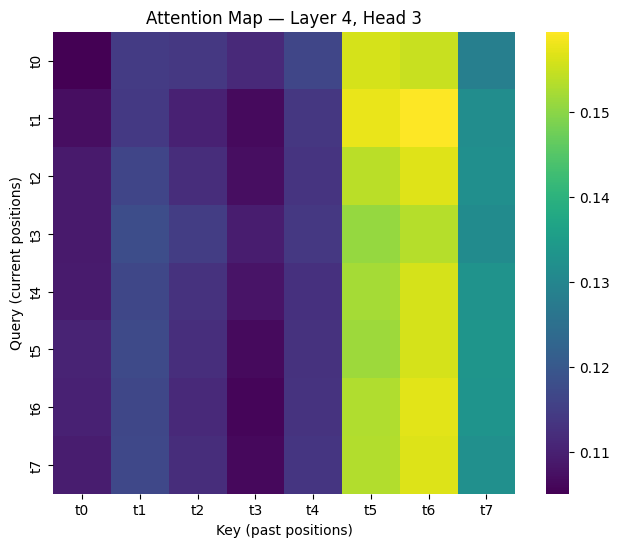

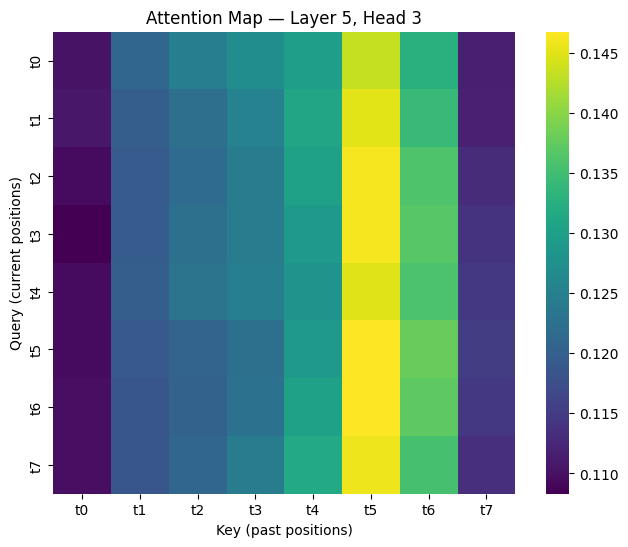

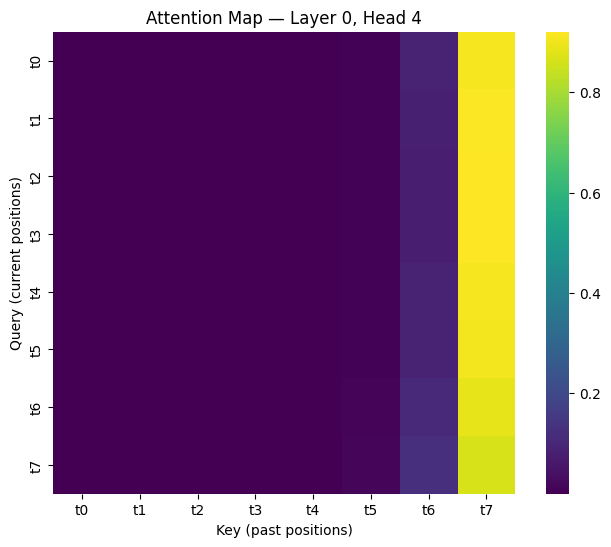

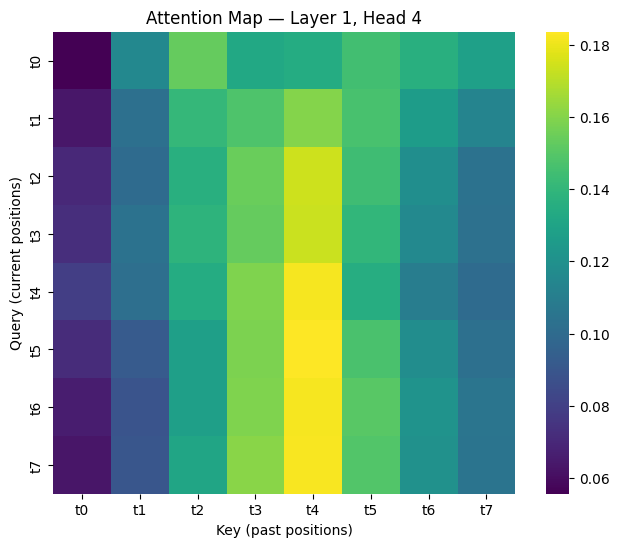

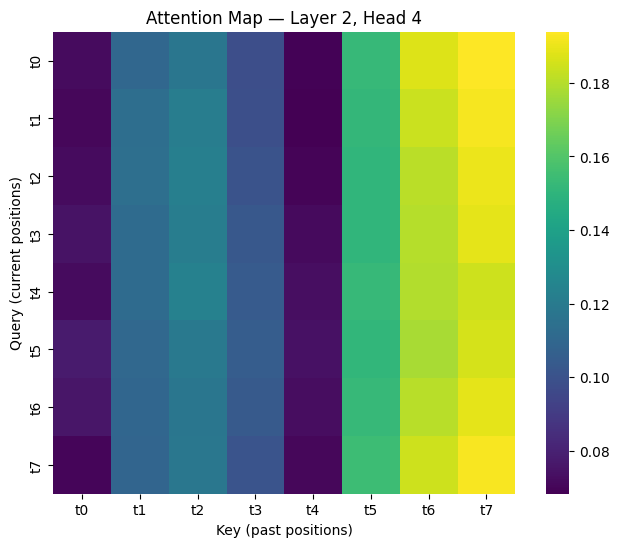

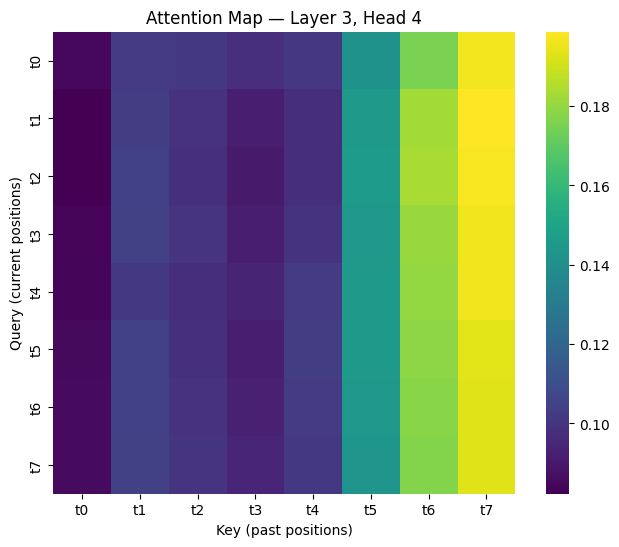

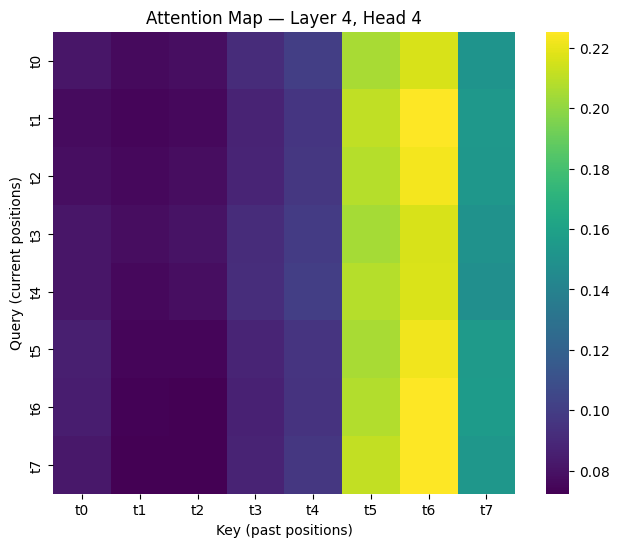

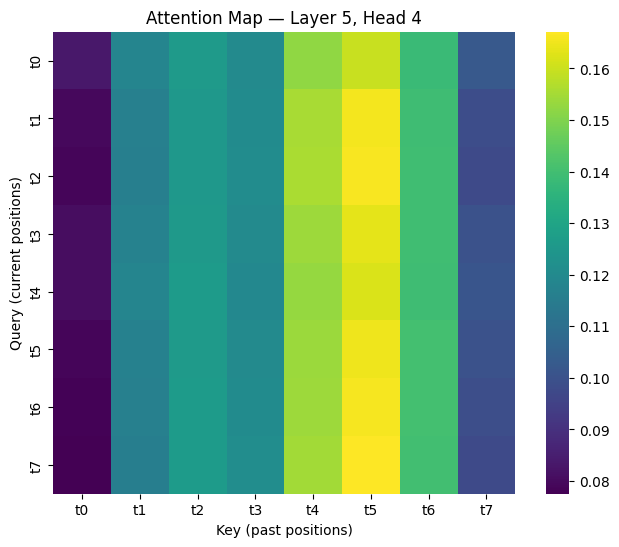

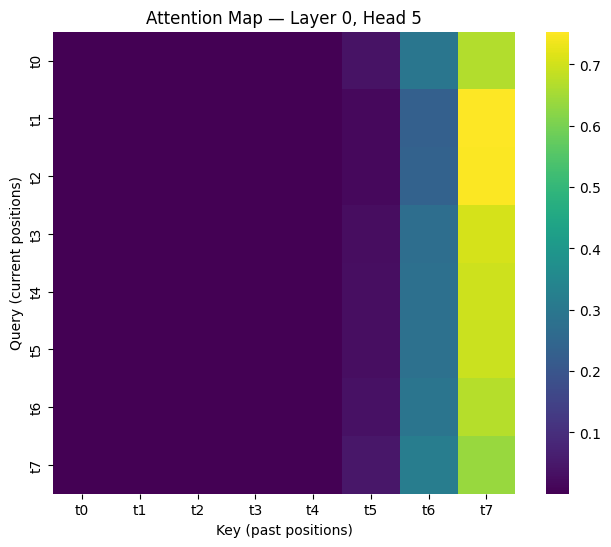

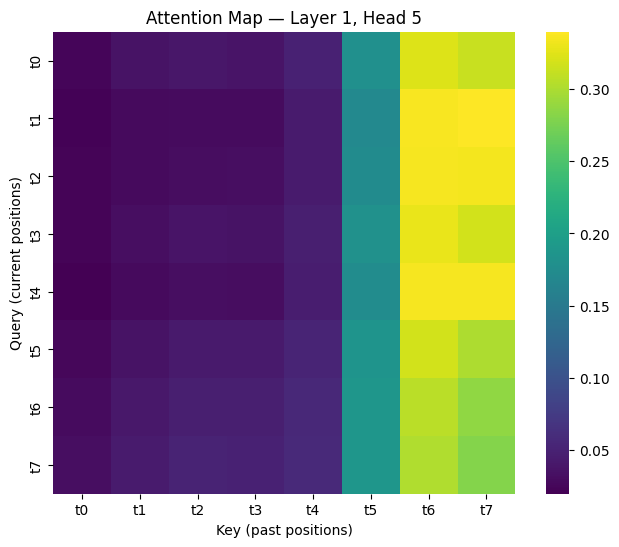

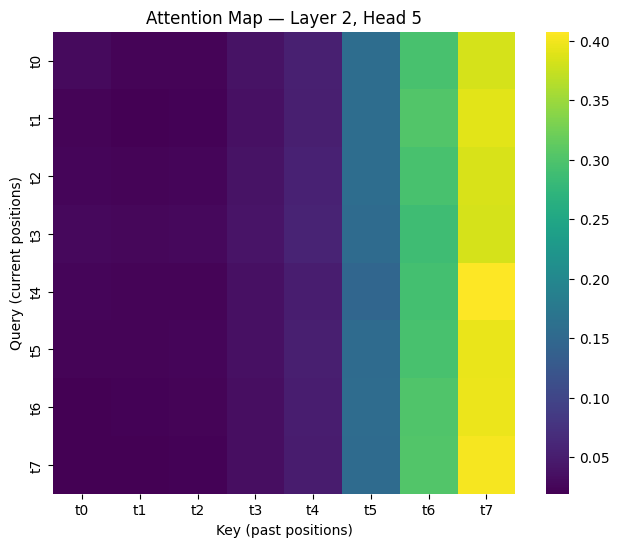

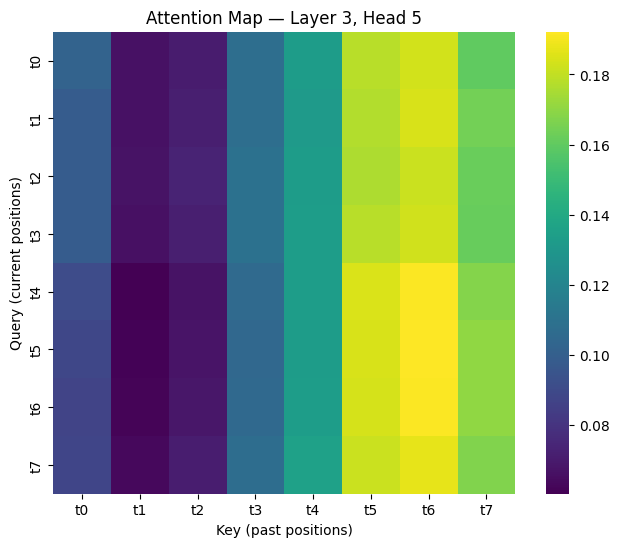

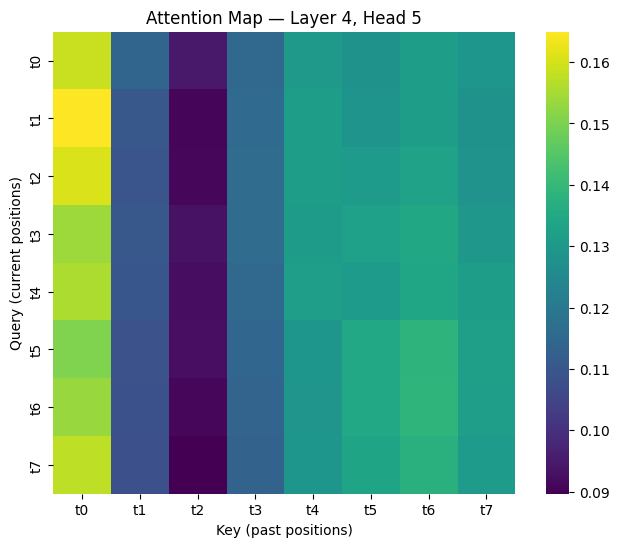

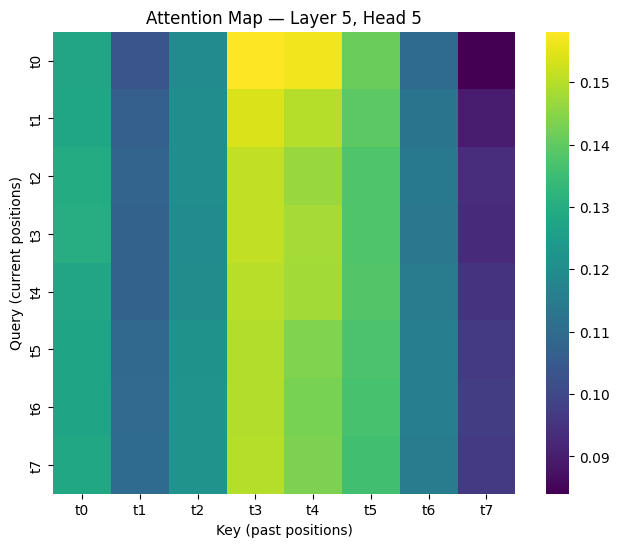

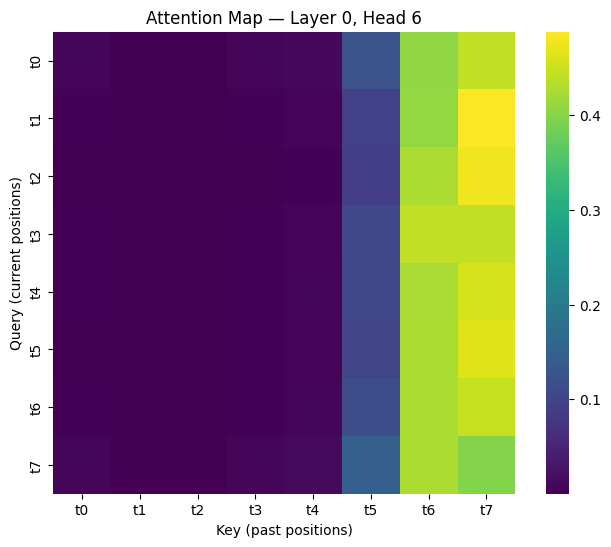

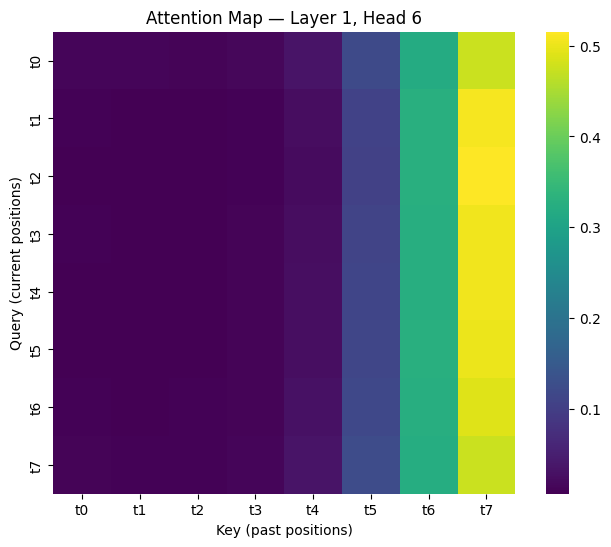

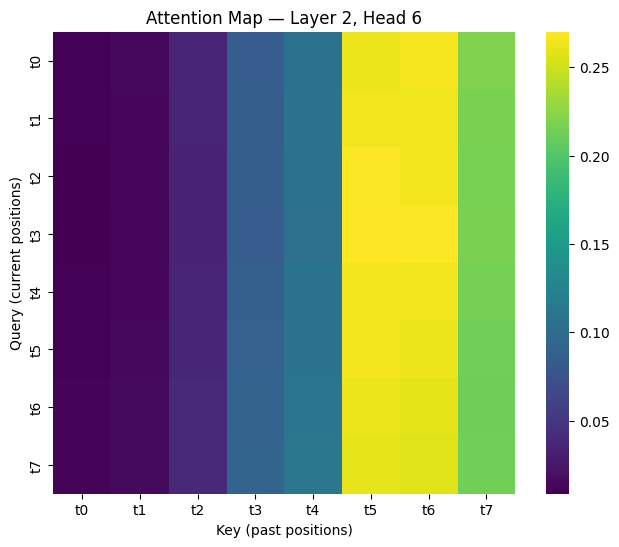

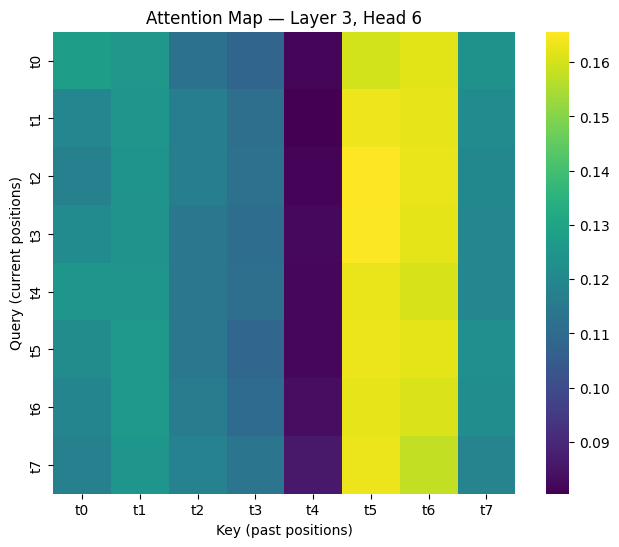

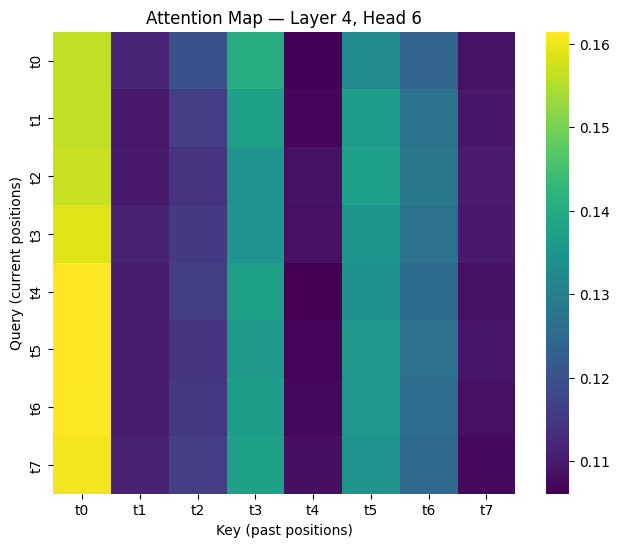

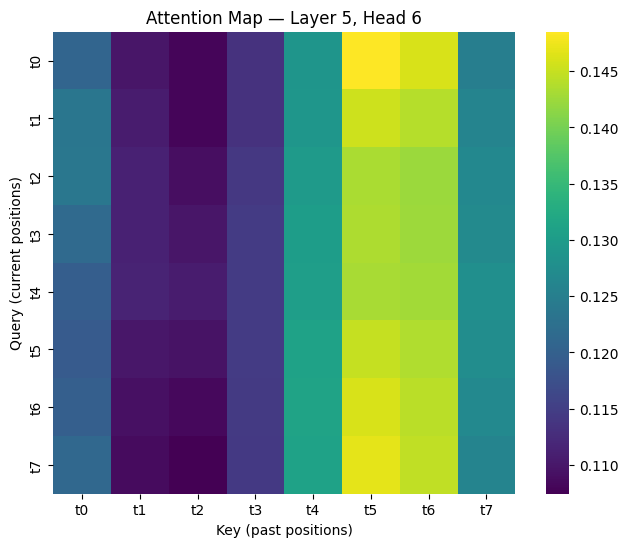

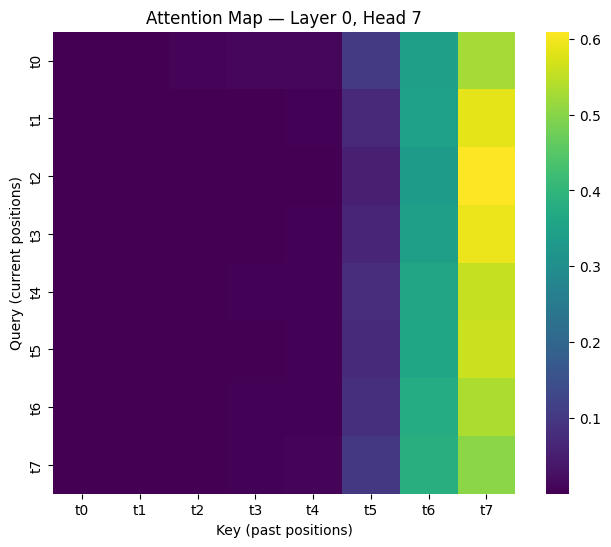

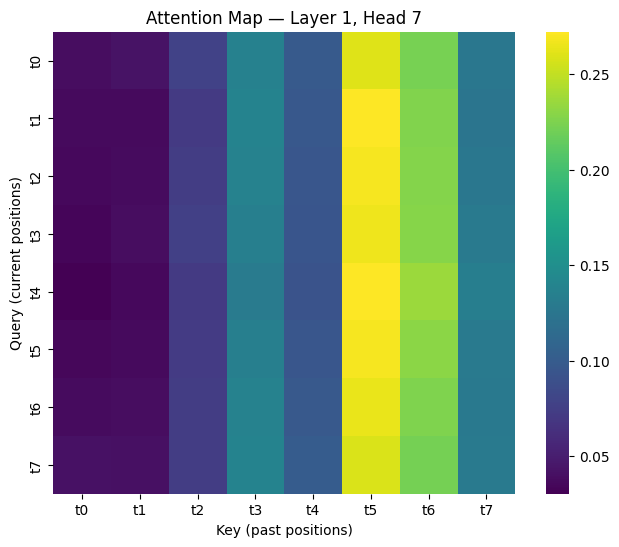

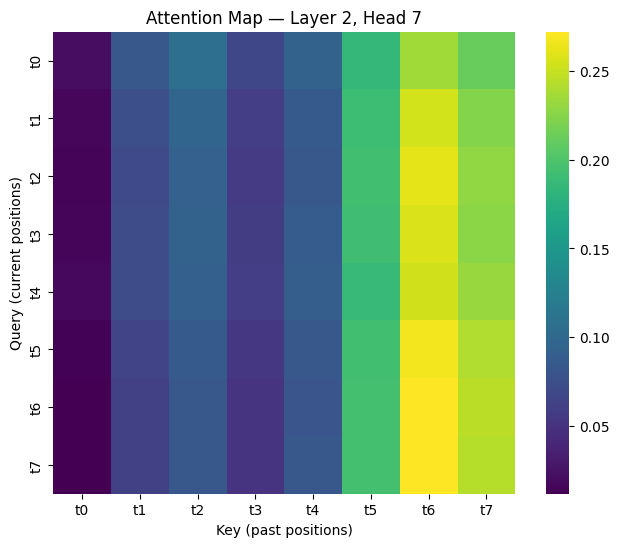

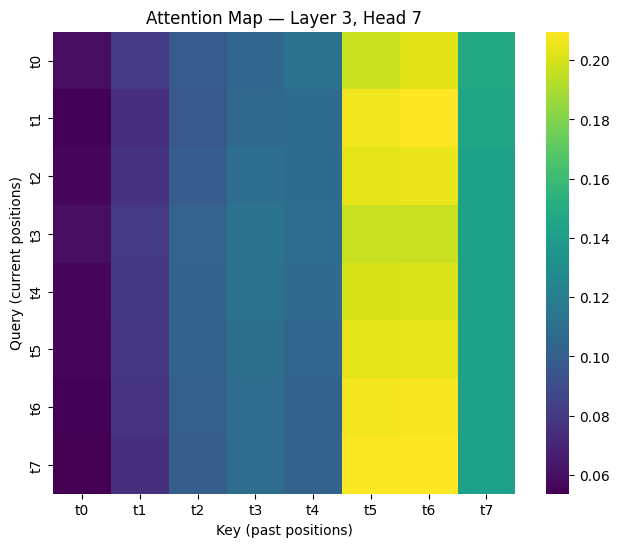

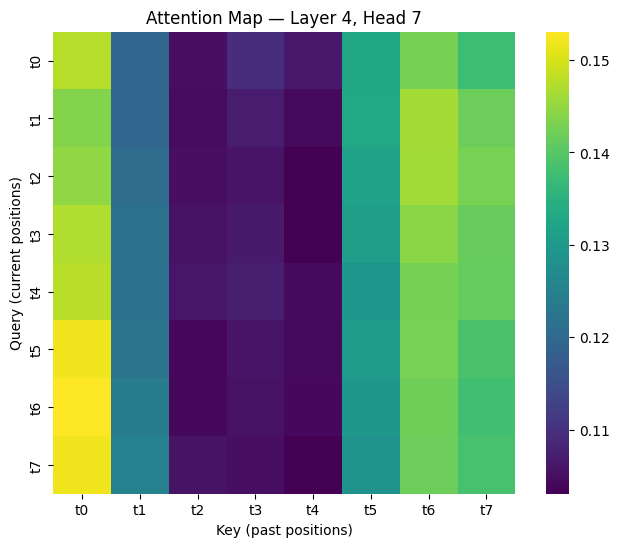

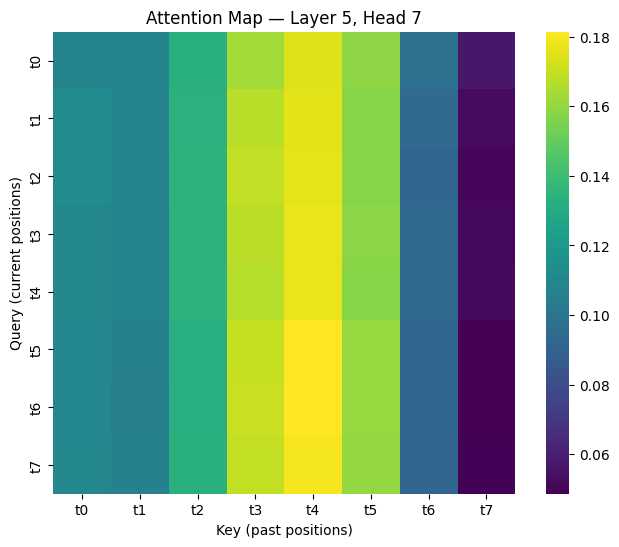

In [ ]:
# for h in range(8):
#   for l in range(6):
#     plot_attention(attentions, layer=l, head=h)

# ## This is very interesting because it explains the concept of long dependencies and how deeper layers mean beiong able to look at short and long dependencies!

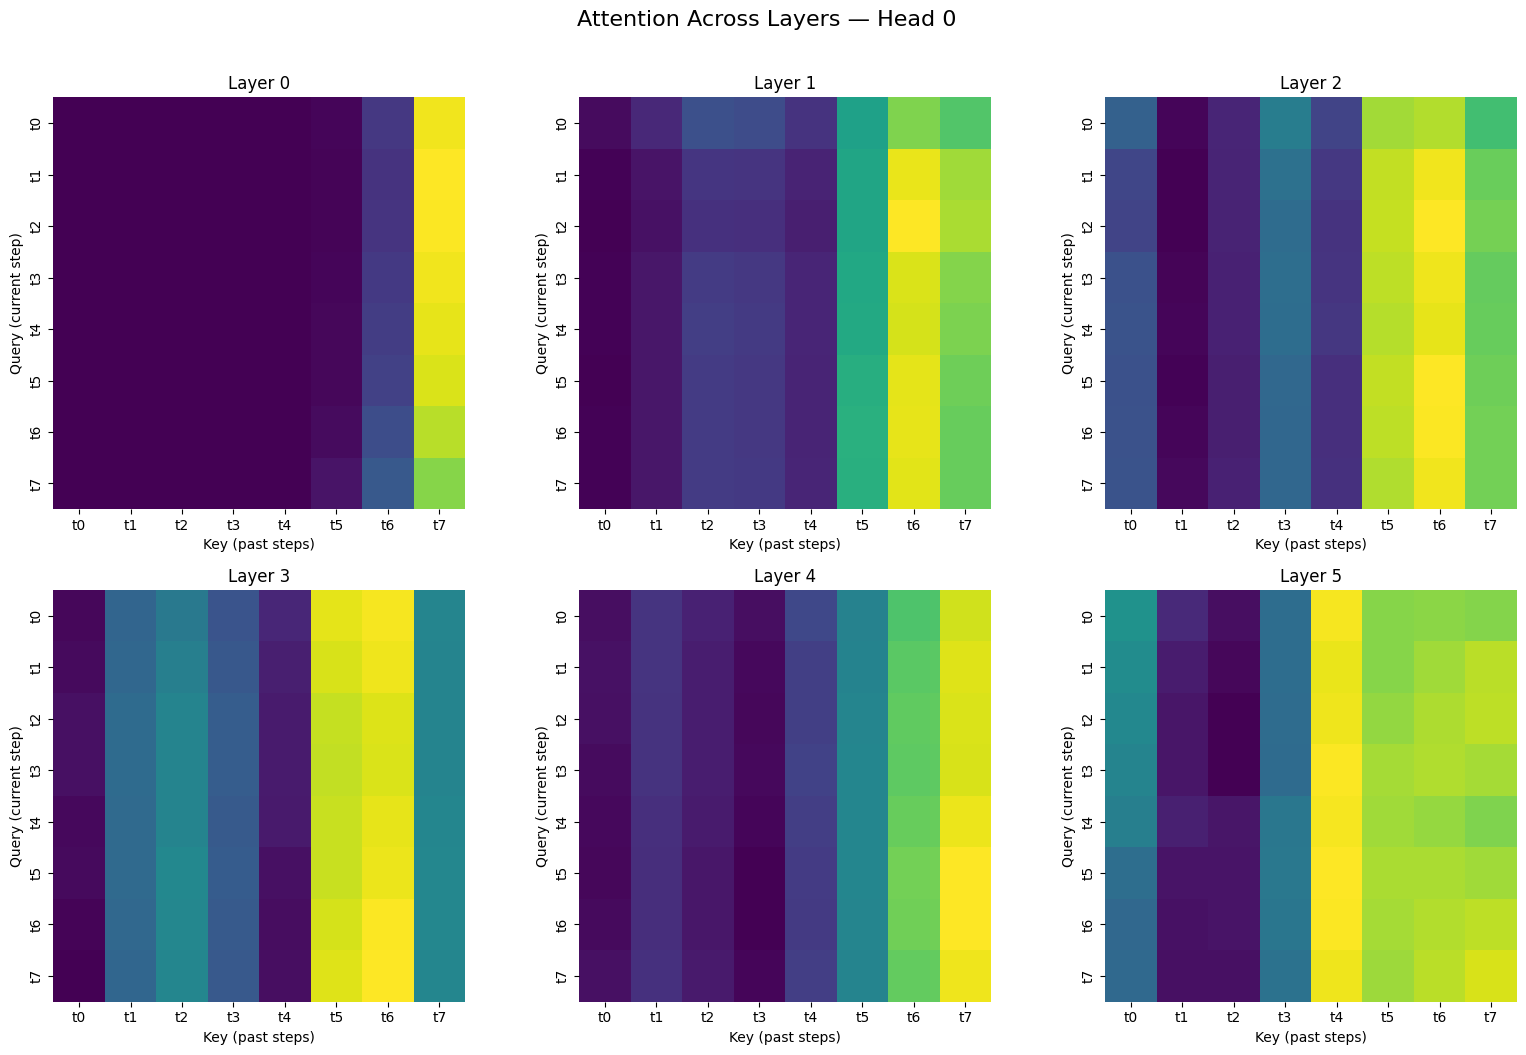

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_across_layers(attn, head=0, time_labels=None, figsize=(16, 10)):
    """
    Plots attention maps across all layers for a single head.

    Args:
        attn: list of attention tensors from each layer (batch, heads, seq_len, seq_len)
        head: index of attention head to visualize
        time_labels: optional list of time-step labels (length = seq_len)
        figsize: size of the full figure
    """
    num_layers = len(attn)
    seq_len = attn[0].shape[-1]

    if time_labels is None:
        time_labels = [f"t{i}" for i in range(seq_len)]

    fig, axs = plt.subplots(2, (num_layers + 1) // 2, figsize=figsize)

    for i in range(num_layers):
        ax = axs[i // ((num_layers + 1) // 2)][i % ((num_layers + 1) // 2)]

        attn_matrix = attn[i][0, head].detach().cpu().numpy()
        sns.heatmap(attn_matrix,
                    xticklabels=time_labels,
                    yticklabels=time_labels,
                    cmap="viridis",
                    square=True,
                    cbar=False,
                    ax=ax)

        ax.set_title(f"Layer {i}")
        ax.set_xlabel("Key (past steps)")
        ax.set_ylabel("Query (current step)")

    plt.tight_layout()
    plt.suptitle(f"Attention Across Layers — Head {head}", fontsize=16, y=1.05)
    plt.show()

sample_input, _ = train_dataset[0]
sample_input = sample_input.unsqueeze(1).to(device)  # (seq_len, 1, features)

model.eval()
with torch.no_grad():
    _, _, _, attentions = model(sample_input)

# Plot attention maps across all layers for Head 0
plot_attention_across_layers(attentions, head=0)



In [ ]:
def plot_attention_across_heads(attn, layer=0, time_labels=None, figsize=(16, 10)):
    """
    Plots attention maps for all heads in a single Transformer layer.

    Args:
        attn: list of attention tensors from each layer (batch, heads, seq_len, seq_len)
        layer: which layer to visualize
        time_labels: optional list of time-step labels
        figsize: size of the figure
    """
    attn_layer = attn[layer]  # (batch, heads, seq_len, seq_len)
    num_heads = attn_layer.shape[1]
    seq_len = attn_layer.shape[-1]

    if time_labels is None:
        time_labels = [f"t{i}" for i in range(seq_len)]

    cols = (num_heads + 1) // 2
    fig, axs = plt.subplots(2, cols, figsize=figsize)

    for h in range(num_heads):
        ax = axs[h // cols][h % cols]

        attn_matrix = attn_layer[0, h].detach().cpu().numpy()
        sns.heatmap(attn_matrix,
                    xticklabels=time_labels,
                    yticklabels=time_labels,
                    cmap="viridis",
                    square=True,
                    cbar=False,
                    ax=ax)

        ax.set_title(f"Head {h}")
        ax.set_xlabel("Key (past steps)")
        ax.set_ylabel("Query (current step)")

    plt.tight_layout()
    plt.suptitle(f"Attention Across Heads — Layer {layer}", fontsize=16, y=1.05)
    plt.show()


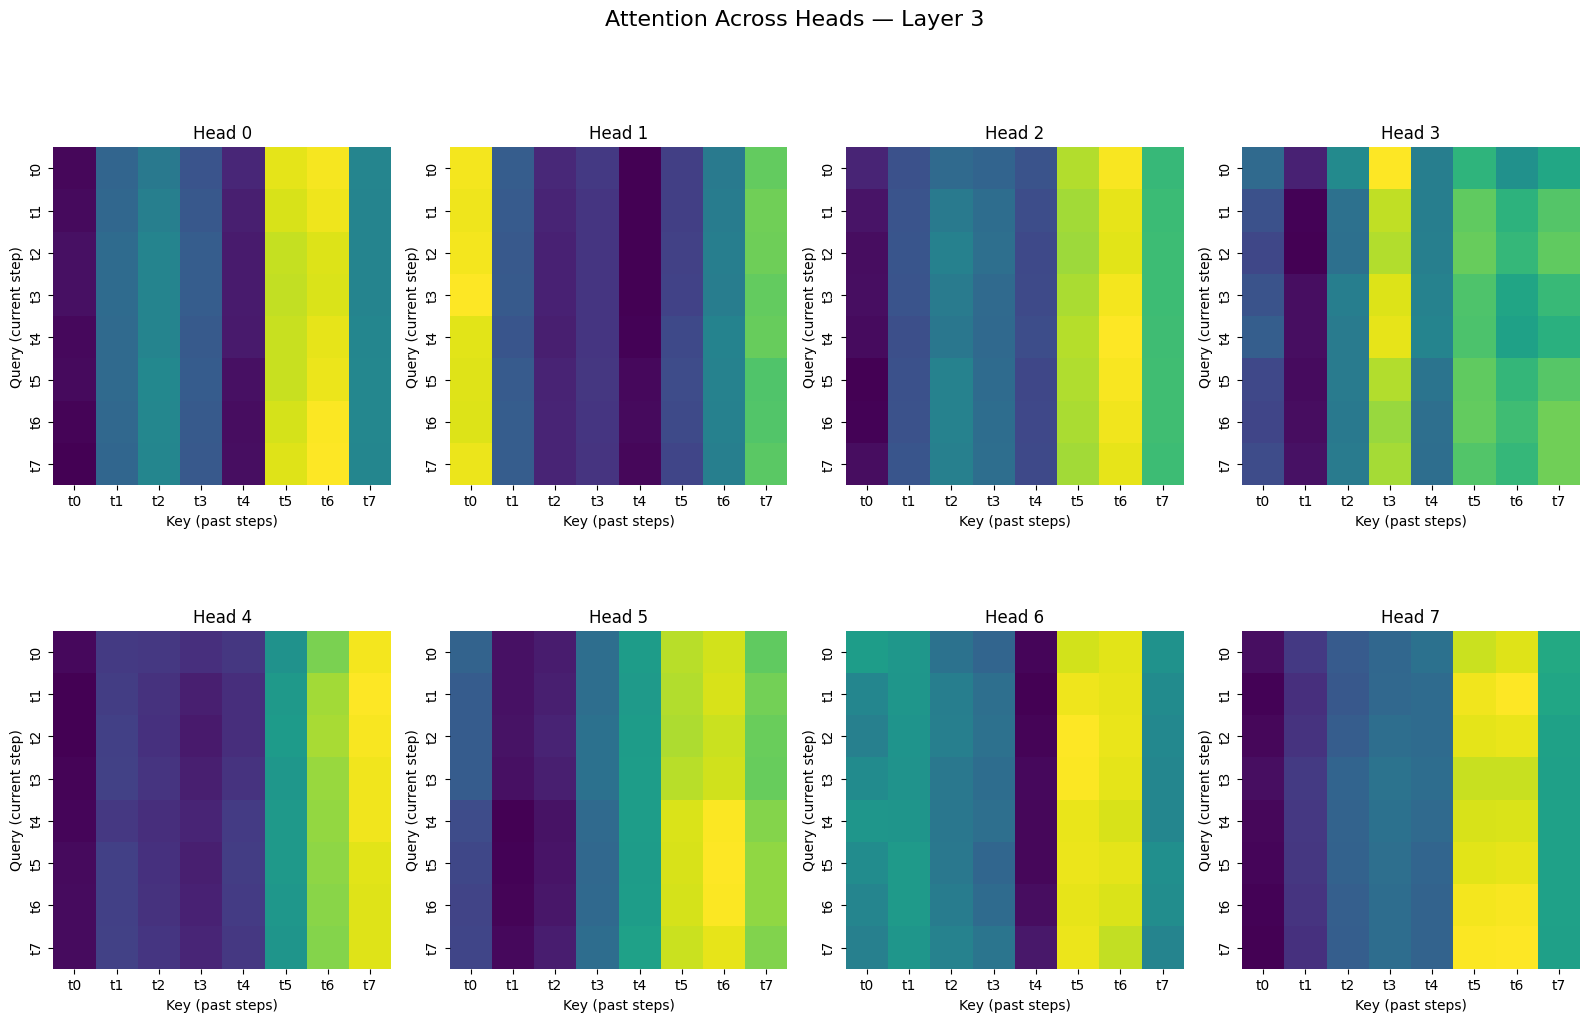

In [ ]:
# Plot all heads in Layer 3
plot_attention_across_heads(attentions, layer=3)

# Typical differences between heads:

# Some focus tightly on recent time steps (diagonal)

# Others jump to the beginning (e.g., t0)

# Some spread out attention → global heads



🔸 Local Heads:
Heads 0, 4, and 5 are heavily focused on recent steps

These are probably modeling short-term momentum, like immediate past → next prediction

🔸 Global/Semi-Global Heads:
Head 1: Strong on t0 and t7 (first and last steps!) → maybe learning positional anchors

Head 7: Gradual, smooth spread → good sign of global context scanning

🔸 Anchored Heads:
Head 3: Very consistent attention around t3, for all queries

This might indicate a fixed position dependency (e.g., daily rhythm at certain hours)